In [1]:
#General import
from sklearn import metrics
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import List, Tuple
from typing import Sequence

#Qiskit import
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.visualization import circuit_drawer
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap, ZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import XGate, SXGate, RZGate, CXGate
from qiskit.circuit.gate import Gate
from qiskit_machine_learning.utils.loss_functions import KernelLoss, SVCLoss
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel, TrainableKernel, FidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_algorithms.optimizers import SPSA

algorithm_globals.random_seed = 13

#sklearn import
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR
from sklearn.metrics import mean_squared_error

In [16]:
class Individual():
    
    def __init__(
        self,
        numberOfGenes: int,
        numberOfFeatures: int,
        numberOfQubits: int,
        gates = [Gate]
    ) -> None:
    
        self._numberOfFeatures = numberOfFeatures
        self._numberOfGenes = numberOfGenes
        self._numberOfQubits = numberOfQubits
        self._genotype =  [[None, None, None, None] for _ in range(numberOfGenes)]
        self._gates = gates
        
        
    def generateFirstIndividual(
        self
    ) -> None:
        
        featurePositions = []
        
        while len(featurePositions) < self._numberOfFeatures:
            position = random.randint(0, self._numberOfGenes-1)
            if position not in featurePositions:
                featurePositions.append(position)
    
        feature = 0
        for gene in featurePositions:
            qubit = random.randint(0, self._numberOfQubits-1)
            self._genotype[gene][0] = RZGate
            self._genotype[gene][1] = qubit
            self._genotype[gene][2] = None
            self._genotype[gene][3] = feature
            feature = feature + 1    
            
        for gene in [i for i in range(self._numberOfGenes) if i not in featurePositions]:
            
            gate = random.choice(self._gates)
            
            self._genotype[gene][0] = gate
            
            if gate == RZGate:
                
                qubit = random.randint(0, self._numberOfQubits-1)
                feature = random.randint(0, self._numberOfFeatures-1)
                self._genotype[gene][1] = qubit
                self._genotype[gene][2] = None
                self._genotype[gene][3] = feature
                
            elif gate == CXGate:
                
                control_qubit = random.randint(0, self._numberOfQubits-1)
                target_qubit = random.randint(0, self._numberOfQubits-1)
                while target_qubit == control_qubit:
                    target_qubit = random.randint(0, self._numberOfQubits-1)
                    
                self._genotype[gene][1] = target_qubit
                self._genotype[gene][2] = control_qubit
                self._genotype[gene][3] = None
                
            else:
                
                qubit = random.randint(0, self._numberOfQubits-1)
                self._genotype[gene][1] = qubit
                self._genotype[gene][2] = None
                self._genotype[gene][3] = None


    @property
    def numberOfFeatures(self) -> int:
        return self._numberOfFeatures
    
    @property
    def numberOfQubits(self) -> int:
        return self._numberOfQubits
    
    @property
    def numberOfGenes(self) -> int:
        return self._numberOfGenes
    
    @property
    def gates(self) -> List[Gate]:
        return self._gates
    
    @property 
    def genotype(self) -> List[Tuple[Gate, int, int, int]]:
        return self._genotype
    
    @genotype.setter 
    def genotype(self, new_genotype: List[Tuple[Gate, int, int, int]]):

        if len(new_genotype)!=self._numberOfGenes:
                raise ValueError('Wrong genotype lenght')
        
        self._genotype = new_genotype
        

    def getFenotype(
        self
    ) -> QuantumCircuit:
        
        trainingParams = ParameterVector('x', self._numberOfFeatures)
        
        fenotype = QuantumCircuit(self._numberOfQubits)
        
        for gene in range(self._numberOfGenes):
                
                gate = self._genotype[gene][0]

                if gate == RZGate:
                    fenotype.append(gate(trainingParams[self._genotype[gene][3]]), [self._genotype[gene][1]])
                    
                elif gate == CXGate:
                    fenotype.append(gate(), [self._genotype[gene][2], self._genotype[gene][1]])
                    
                else:
                    fenotype.append(gate(), [self._genotype[gene][1]])    

                fenotype.barrier()    

        return fenotype


    def getFeatureMask(
        self
    ) -> np.ndarray:
        
        feature_mask = np.zeros(self._numberOfFeatures, dtype=bool)

        for gene in range(self._numberOfGenes):
            
            if self._genotype[gene][0] == RZGate:
                feature_mask[self._genotype[gene][3]] = 1

        return feature_mask
        

    def mutate(
        self, 
        probability: float = 0.1
    ) -> None:
        
        for gene in range(0, self._numberOfGenes):
            
            if random.random() < probability: 
                
                self._genotype[gene] = [None, None, None, None]
                
                gate = random.choice(self._gates)
            
                self._genotype[gene][0] = gate

                if gate == RZGate:
                    
                    qubit = random.randint(0, self._numberOfQubits-1)
                    feature = random.randint(0, self._numberOfFeatures-1)
                    self._genotype[gene][1] = qubit
                    self._genotype[gene][2] = None
                    self._genotype[gene][3] = feature
                    
                elif gate == CXGate:
                    
                    control_qubit = random.randint(0, self._numberOfQubits-1)
                    target_qubit = random.randint(0, self._numberOfQubits-1)
                    while target_qubit == control_qubit:
                        target_qubit = random.randint(0, self._numberOfQubits-1)
                        
                    self._genotype[gene][1] = target_qubit
                    self._genotype[gene][2] = control_qubit
                    self._genotype[gene][3] = None
                    
                else:
                    
                    qubit = random.randint(0, self._numberOfQubits-1)
                    self._genotype[gene][1] = qubit
                    self._genotype[gene][2] = None
                    self._genotype[gene][3] = None


def crossover(
    parent1: Individual,
    parent2: Individual,
    type: str
    ) -> Individual:

        if (
            parent1.numberOfFeatures != parent2.numberOfFeatures or
            parent1.numberOfGenes != parent2.numberOfGenes or
            parent1.numberOfQubits != parent2.numberOfQubits or
            parent1.gates != parent2.gates 
        ):      
            raise ValueError("Incompatabile parents") 

        if type not in ("Type 1", "Type 2"):
            raise ValueError("Non existent type") 

        child = Individual(
            numberOfFeatures=parent1.numberOfFeatures, 
            numberOfGenes=parent1.numberOfGenes, 
            numberOfQubits=parent1.numberOfQubits, 
            gates=parent1.gates
        )
      
        division_point = parent1.numberOfGenes // 2 #point where the circuit is cut

        if type=="Type 1":
            child.genotype = np.concatenate((parent1.genotype[:division_point], parent2.genotype[division_point:]))
        
        elif type=="Type 2":
            child.genotype = np.concatenate((parent2.genotype[:division_point], parent1.genotype[division_point:]))

        return child
        
def fit(
    individual: Individual, 
    X_train: np.ndarray,
    y_train: np.ndarray, 
    X_test: np.ndarray, 
    y_test: np.ndarray
) -> float:
        
    feature_map = individual.getFenotype()
    feature_mask = individual.getFeatureMask()        
    kernel = FidelityQuantumKernel(feature_map=feature_map)
    svr = SVR(kernel=kernel.evaluate)
    svr.fit(X_train[:, feature_mask], y_train)
    return len(y_test)/np.sqrt(mean_squared_error(svr.predict(X_test[:, feature_mask]), y_test))

def prob(x, exp=6):
    return [i for i in x]


def levy(X):
    y = np.zeros(X.shape[0])
    for i in range(len(y)):
        y[i] = (np.sin(3*np.pi*X[i][0]))**2 + (X[i][0]-1)**2 * (1 + (np.sin(3*np.pi*X[i][1]))**2) + (X[i][1]-1)**2 * (1 + (np.sin(3*np.pi*X[i][1]))**2)

    return y

def trivial(X):
    y = np.zeros(X.shape[0])
    for i in range(len(y)):
        y[i] = X[i][0]+X[i][1]

    return y

In [42]:
X = np.random.uniform(-10, 10, size=(70,2))
y = levy(X)

feature_dimension = X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=14)

#https://www.tensorflow.org/tutorials/structured_data/time_series?hl=it
#https://en.wikipedia.org/wiki/Time_series

print(X_test.shape[0])

21


In [26]:
maximumGenerations = 25
numberOfGenes = 10
numberOfQubits = 3
gates = [XGate, SXGate, RZGate, CXGate]
k = 10 #number of individuals surviving each generation
elite_dimension = k // 10 
numberOfGenerations = 0
bestFitness = 0

#Generate the first k individuals
currentGeneration = []
currentGenerationFitness = []
meanFitness = []

for i in range(k):
    print(f'Generating initial individual number {i+1} and evaluating fitness...')
    currentGeneration.append(Individual(numberOfFeatures=X_train.shape[1], numberOfGenes=numberOfGenes, numberOfQubits=numberOfQubits, gates=gates))
    currentGeneration[i].generateFirstIndividual()
    currentGenerationFitness.append(fit(currentGeneration[i], X_train, y_train, X_test, y_test))
    print(f'Inizial individual number {i+1}')
    print(f'Fitness: {currentGenerationFitness[i]}')
    #print(circuit_drawer(currentGeneration[i].getFenotype()))

meanFitness.append(np.mean(currentGenerationFitness))

badIndividual = currentGeneration[0] #I save one of the first for future comparison

numberOfGenerations = numberOfGenerations+1

while numberOfGenerations < maximumGenerations: 
    
    print(f'Generation number {numberOfGenerations}')
    print('')
    numberOfGenerations = numberOfGenerations+1

    childs=[]
    childsFitness=[]

    probabilities = prob(currentGenerationFitness)
    probabilities = probabilities / np.sum(probabilities)

    #pass the elite individual to the child generation as they are
    for _ in range(elite_dimension):
        elite_indices = np.argpartition(currentGenerationFitness, len(currentGenerationFitness)-1, axis=0)[(len(currentGenerationFitness)-elite_dimension):]
        childsFitness = np.take(currentGenerationFitness, elite_indices, axis=0).tolist()
        childs = np.take(currentGeneration, elite_indices, axis=0).tolist()

    #Create the childs
    for i in range(k-elite_dimension):

        print(f'Generating child {i+1}...')
        first_parent_index = np.random.choice(len(probabilities), p=probabilities)
        second_parent_index = np.random.choice(len(probabilities), p=probabilities)
        while first_parent_index==second_parent_index:
            second_parent_index = np.random.choice(len(probabilities), p=probabilities)

        first_parent = currentGeneration[first_parent_index]
        second_parent = currentGeneration[second_parent_index]
        child1 = crossover(first_parent, second_parent, type="Type 1")
        child2 = crossover(first_parent, second_parent, type="Type 2")
        child1.mutate()
        child2.mutate()
        child1_fitness = fit(child1, X_train, y_train, X_test, y_test)
        child2_fitness = fit(child2, X_train, y_train, X_test, y_test)

        if  child1_fitness > child2_fitness:
            childs.append(deepcopy(child1))
            childsFitness.append(child1_fitness)
        else:
            childs.append(deepcopy(child2))    
            childsFitness.append(child2_fitness)


    currentGeneration = deepcopy(childs)
    currentGenerationFitness = deepcopy(childsFitness)
    meanFitness.append(np.mean(currentGenerationFitness))

    #Print the generation
    print('')
    for i in range(k):
        print(f'Individual number {i+1}')
        print(f'Fitness: {currentGenerationFitness[i]}')
        #print(circuit_drawer(currentGeneration[i].getFenotype()))

    #Print best fitness of the generation
    print('')
    bestFitness = np.max(currentGenerationFitness)
    print(f'The best fitness of the generation is {bestFitness}')
    print('--------------------------------')

Generating initial individual number 1 and evaluating fitness...
Inizial individual number 1
Fitness: 0.30058403891869806
Generating initial individual number 2 and evaluating fitness...
Inizial individual number 2
Fitness: 0.30058403891869806
Generating initial individual number 3 and evaluating fitness...
Inizial individual number 3
Fitness: 0.3019879669399241
Generating initial individual number 4 and evaluating fitness...
Inizial individual number 4
Fitness: 0.3049939509267574
Generating initial individual number 5 and evaluating fitness...
Inizial individual number 5
Fitness: 0.30058403891869806
Generating initial individual number 6 and evaluating fitness...
Inizial individual number 6
Fitness: 0.3056512183210519
Generating initial individual number 7 and evaluating fitness...
Inizial individual number 7
Fitness: 0.3066228700702825
Generating initial individual number 8 and evaluating fitness...
Inizial individual number 8
Fitness: 0.30058403891869806
Generating initial individua

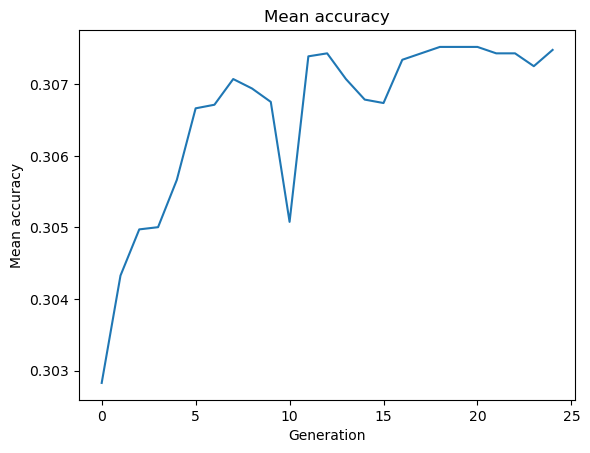

In [31]:
plt.plot(meanFitness)
plt.title("Mean accuracy")
plt.xlabel("Generation")
plt.ylabel("Mean accuracy")
plt.show()

In [32]:
X = np.random.uniform(-10, 10, size=(200,2))
y = levy(X)

feature_dimension = X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=14)

In [37]:
print(f'Fitness: {currentGenerationFitness[0]}')
feature_map = currentGeneration[0].getFenotype()
feature_mask=currentGeneration[0].getFeatureMask()
kernel = FidelityQuantumKernel(feature_map=feature_map)
#print(circuit_drawer(feature_map))
#fit classical SVM
svr = SVR(kernel=kernel.evaluate, C=1) 
svr.fit(X_train[:, feature_mask],y_train)

mse = mean_squared_error(svr.predict(X_test[:, feature_mask]), y_test)
rmse = np.sqrt(mse)
print("Inverse Root Mean Squared Error:", len(y_test)/rmse)



Fitness: 0.30751958713849886
Inverse Root Mean Squared Error: 0.9641815838078608


In [35]:
#fit classical SVR with rbf kernel
svr = SVR(kernel='rbf', epsilon=0) 
svr.fit(X_train, y_train)

mse = mean_squared_error(svr.predict(X_test), y_test)
rmse = np.sqrt(mse)
print("Inverse Root Mean Squared Error:", len(y_test)/rmse)

Inverse Root Mean Squared Error: 1.093969162443476


In [36]:
#fit classical SVR with NOT optimized quantum kernel
feature_map1 = ZZFeatureMap(feature_dimension)
kernel = FidelityQuantumKernel(feature_map=feature_map1)
svr = SVR(kernel=kernel.evaluate, epsilon=0) 
svr.fit(X_train, y_train)

mse = mean_squared_error(svr.predict(X_test), y_test)
rmse = np.sqrt(mse)
print("Inverse Root Mean Squared Error:", len(y_test)/rmse)

Inverse Root Mean Squared Error: 0.9577861615005611
